In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import re
from sklearn import feature_extraction, linear_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import random
from collections import Counter
from wordcloud import WordCloud
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping


### NLP Disaster Tweets Kaggle Mini-Project

The goal of this competition is to develop a machine learning model that can distinguish between Tweets regarding actual disasters and those that aren't. A dataset of 10,000 hand-classified tweets will be made available to you.

The competition's objective is to create a machine learning model that can determine whether or not a particular tweet is connected to a real tragedy. The participants are given access to a dataset of 10,000 manually labeled tweets. The main objective is to train and assess algorithms that can reliably categorize tweets into disaster-related and non-disaster-related groups using this data.


In [2]:
PathDir = '/kaggle/input/nlp-getting-started/'
train_df = pd.read_csv(PathDir + 'train.csv')
test_df = pd.read_csv(PathDir + 'test.csv')


###  Exploratory Data Analysis (EDA)
he dataset was shuffled to ensure random distribution and displayed basic info, showing that:

Unique Text Count: There are 7503 unique text entries, suggesting some duplication.
Empty Text Entries: No empty text entries were found in text_clean.
2.2 Character Count Analysis
Character counts for each text entry were analyzed and visualized based on the target variable. The distribution plot (shown in the second image) indicates:

Character Length Distribution: Non-disaster tweets (target=0) tend to have a higher character count than disaster tweets (target=1).
This insight might suggest that tweets related to disasters are more concise or direct.
2.3 Target Class Distribution
A bar chart was created to show the count of each target class, providing insights into class imbalance, if any. This information is essential for model training to ensure balanced predictions.

2.4 Word Cloud
A Word Cloud was generated to visualize the most frequent words in the tweets. This helped identify common terms and potential keywords that appear frequently in disaster and non-disaster tweets. For instance, terms like "blood," "injury," and "devastation" may hint at disaster-related content.

3. Model Building and Training
3.1 Data Preparation
The dataset was split into training and validation sets:

Text Tokenization: Used a tokenizer to consider the top 10,000 words.
Sequence Conversion and Padding: Converted text data into sequences and padded each sequence to a maximum length of 100 words.
Target Encoding: Target labels were converted to numpy arrays to be compatible with the model training process.
3.2 Model Architecture
A Sequential neural network model was designed for this binary classification task. The architecture included:

Embedding Layer: Encodes each word into a vector of a specified dimension (e.g., 100).
LSTM Layers: Two LSTM layers were used to capture sequential dependencies in the text data.
Dropout Layers: Regularization layers to prevent overfitting.
Dense Output Layer: A single neuron with sigmoid activation for binary classification.
3.3 Training Process
The model was compiled using binary cross-entropy as the loss function and the Adam optimizer, and trained with early stopping to prevent overfitting. Training accuracy and validation accuracy were tracked to ensure the model's performance on unseen data.

In [24]:
def analyze_text_data(train_df):
    
    # Shuffle the DataFrame
    train_df = train_df.sample(frac=1, random_state=9222).reset_index(drop=True)
    
    # Display basic info
    train_df.info()
    
    # Display the first few rows
    display(train_df.head())
    
    # Unique text count
    unique_text_count = train_df['text'].nunique()
    print("Unique text count:", unique_text_count)
    
    # Empty text count
    empty_text_count = train_df[train_df['text'] == ''].shape[0]
    print("Empty text entries:", empty_text_count)
    
    # Generate and display WordCloud
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(' '.join(train_df['text'].dropna()))
    plt.figure(figsize=(10, 15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud of Texts")
    plt.show()
    
    # Plot target distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=train_df, x='target', palette=['blue', 'red'])
    plt.title("Target Distribution")
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.show()
    
    train_df['char_count'] = train_df['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_df, x='char_count', hue='target', bins=30, kde=True, 
                     palette={0: 'blue', 1: 'orange'}, element='step')
    plt.title("Character Counts Histogram by Target")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
def plot_top_keywords_pie(train_df, top_n=20):
    """
    Plots a pie chart of the top N most frequent keywords in the 'keyword' column.
    
    Parameters:
    - train_df: DataFrame containing a 'keyword' column.
    - top_n (int): Number of top keywords to include in the pie chart.
    """
    # Get the top N keywords
    top_keywords = train_df['keyword'].value_counts().nlargest(top_n)
    
    # Plot pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(top_keywords, labels=top_keywords.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Top {top_n} Keywords Distribution")
    plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   text_clean  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


,id,keyword,location,text,target,text_clean
0,1244,blood,"Seattle, WA",@Chambered_Blood Yeah you are! #SpeakingFromEx...,0,chamberedblood yeah you are speakingfromexperi...
1,334,annihilated,NaN,@TomcatArts thus explaining why you were all a...,1,tomcatarts thus explaining why you were all an...
2,6555,injury,NaN,@AdamRubinESPN Familia: arm injury or head case?,1,adamrubinespn familia arm injury or head case
3,7168,mudslide,London,#GBBO The difference between Paul and Mary my ...,0,gbbo the difference between paul and mary my d...
4,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0,from devastation to elation getting back on my...


Unique text count: 7503
Empty text entries: 0


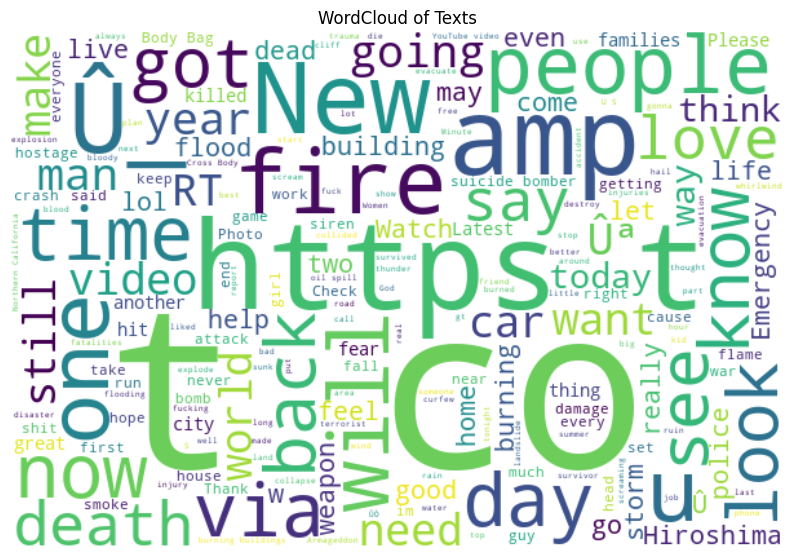

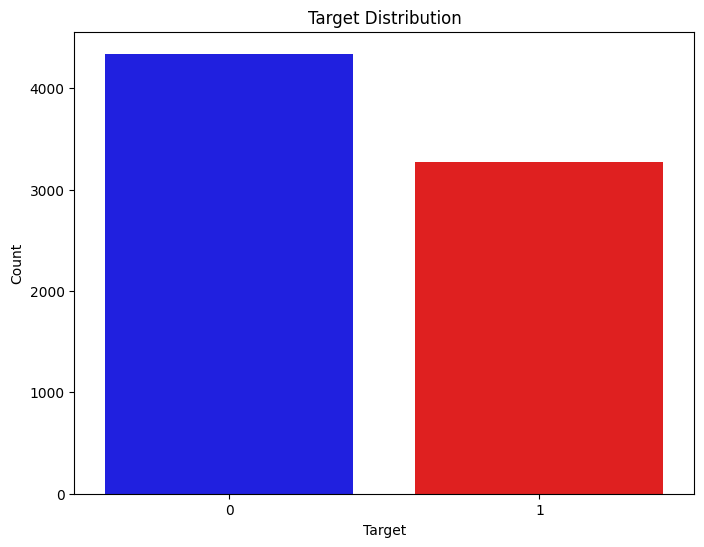

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

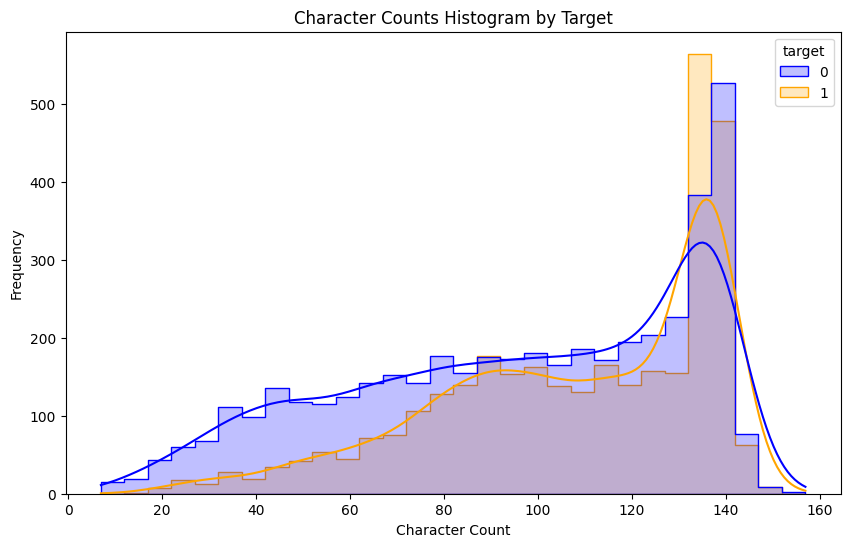

In [25]:
analyze_text_data(train_df)


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0       1  our deeds are the reason of this earthquake ma...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1  people receive wildfires evacuation orders in ...  
4       1  just got sent this photo from ruby alaska as s...  



   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1

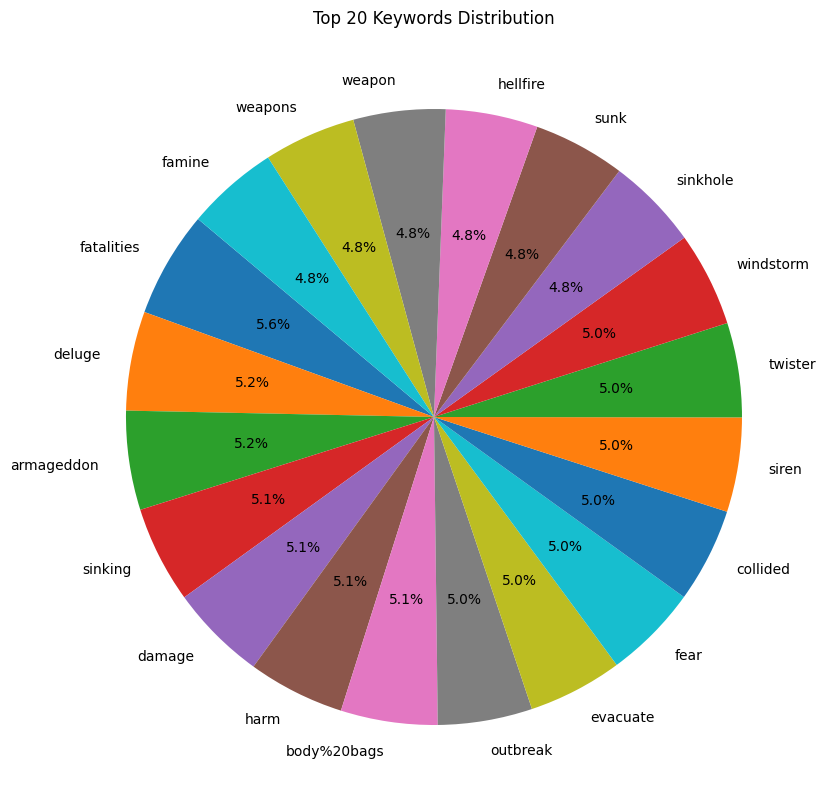

In [14]:
def clean_text(text):
    """
    Cleans a single text string by:
    - Removing URLs
    - Stripping HTML tags
    - Removing special characters and numbers
    - Converting to lowercase
    - Removing extra spaces
    """
    text = re.sub(r'http\S+', '', text)               # Remove URLs
    text = re.sub(r'<.*?>', '', text)                 # Remove HTML tags
    text = re.sub(r'[^A-Za-z\s]', '', text)           # Remove special characters and numbers
    text = text.lower()                               # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()          # Remove extra spaces
    return text
# clean `text` column & add it as `text_clean` column
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

# check changes
print(f'\n{train_df.head()}\n\n')
print(f'\n{test_df.head()}\n')
plot_top_keywords_pie(train_df, top_n=20)


### Training Process
The model was compiled using binary cross-entropy as the loss function and the Adam optimizer, and trained with early stopping to prevent overfitting. Training accuracy and validation accuracy were tracked to ensure the model's performance on unseen data.

In [15]:
def prepare_text_data(train_df, test_size=0.2, max_words=10000, max_len=100, random_state=500):

    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        train_df['text'], train_df['target'], test_size=test_size, 
        random_state=random_state, stratify=train_df['target']
    )
    
    # Tokenize text
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    
    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    
    # Pad sequences
    X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_seq = pad_sequences(X_val_seq, maxlen=max_len)
    
    # Convert target labels to numpy arrays
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    
    return X_train_seq, X_val_seq, y_train, y_val, tokenizer

# Example usage:
X_train_seq, X_val_seq, y_train, y_val, tokenizer = prepare_text_data(train_df)

### Model Architecture
This model is a sequential neural network designed for binary text classification (e.g., disaster vs. non-disaster tweets). It consists of several layers to process and classify text data.

Input Layer:

Shape: (100,), indicating an input sequence length of 100.
Embedding Layer:

Parameters: input_dim=10000 (vocabulary size), output_dim=100 (embedding dimension).
This layer converts each word in the input sequence into a 100-dimensional vector, effectively transforming the text into a dense numerical representation.
First LSTM Layer:

Units: 64, with return_sequences=True.
The first LSTM layer captures sequential dependencies within the text and outputs a sequence to pass to the next layer.
LSTMs are useful for handling sequence data because they can maintain information over long text sequences.
Dropout Layer:

Dropout Rate: 0.5 (50%).
This layer helps prevent overfitting by randomly deactivating 50% of the neurons during training, encouraging the model to generalize better.
Second LSTM Layer:

Units: 32, with return_sequences=False.
This layer processes the output from the previous LSTM layer and outputs a single vector representing the processed sequence.
Second Dropout Layer:

Dropout Rate: 0.5.
Another dropout layer to further mitigate overfitting risks.
Dense Output Layer:

Units: 1, with sigmoid activation.
A single neuron with sigmoid activation provides a probability score for binary classification (predicting disaster or non-disaster).
Model Compilation
Loss Function: Binary Cross-Entropy, which is standard for binary classification tasks.
Optimizer: Adam, chosen for its adaptability and efficiency in handling sparse gradients.
Metrics: Accuracy, to evaluate how well the model predicts the correct class.


In [16]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, patience=5):

    # Initialize early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'VALIDATION LOSS: {loss:.2f}')
    print(f'VALIDATION ACCURACY: {accuracy:.2f}')
    
    return history, loss, accuracy

# Example usage
model = Sequential([
    Input(shape=(100,)),                         # Input layer with sequence length 100
    Embedding(input_dim=10000, output_dim=100),  # Embedding layer with 10,000 words, 100 dimensions
    LSTM(64, return_sequences=True),             # First LSTM layer with 64 units, returning sequences
    Dropout(0.5),                                # Dropout layer
    LSTM(32),                                    # Second LSTM layer with 32 units
    Dropout(0.5),                                # Another Dropout layer
    Dense(1, activation='sigmoid')               # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()
history, loss, accuracy = train_and_evaluate_model(model, X_train_seq, y_train, X_val_seq, y_val)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,689 (4.02 MB)

 Trainable params: 1,054,689 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.6383 - loss: 0.6182 - val_accuracy: 0.8116 - val_loss: 0.4347
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8692 - loss: 0.3382 - val_accuracy: 0.7892 - val_loss: 0.4756
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9154 - loss: 0.2446 - val_accuracy: 0.7827 - val_loss: 0.5342
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9472 - loss: 0.1722 - val_accuracy: 0.7807 - val_loss: 0.5807
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9584 - loss: 0.1213 - val_accuracy: 0.7833 - val_loss: 0.5993
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9658 - loss: 0.0989 - val_accuracy: 0.7794 - val_loss: 0.7203
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8163 - loss: 0.4290
VALIDATION LOSS: 0.43
VALIDATION ACCURACY: 0.81


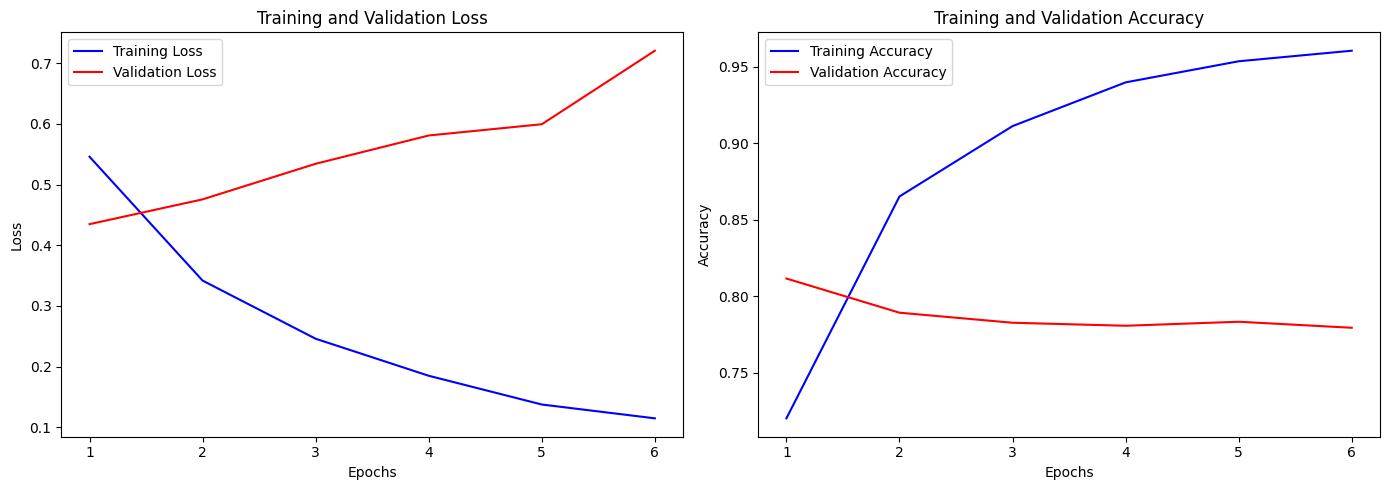

In [17]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the model training history.
    
    Parameters:
    - history: A Keras History object returned by model.fit(), containing training metrics.
    """
    # Extract loss and accuracy metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Define the number of epochs
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])
X_test_seq = pad_sequences(X_test_seq, maxlen=100)

preds = (model .predict(X_test_seq) > 0.5).astype(int)
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': preds.flatten()
})
submission.to_csv('submission.csv', index=False)

### Conflusion
The final Validation Accuracy reached around 0.81, suggesting that the model performs reasonably well on unseen data, though further tuning may improve performance.
This architecture is suitable for text classification tasks and uses recurrent layers (LSTM) to capture sequence dependencies, combined with dropout for regularization.
The model is overfitting, according to the training and validation curves, 
Validation Loss against Training Los:

The model appears to be well fitting the training data as the training loss steadily drops.
But as training goes on, the validation loss rises, suggesting that the model's capacity to generalize to fresh data deteriorates.
Accuracy of Training vs Vali is ion:

Training accuracy gradually increases and becomes closer to perfect accuracy.
On the other hand, beyond the early epochs, the validation accuracy plateaus and even slightly declines, indicating that the model is learning training data-specific patterns but is unable to generalize.
Important. 
Takeaways
Overfitting is a common symptom when a model performs well on training data but poorly on validae Remedies:
Increase n andgularization: Increasing dropout rates or adding more dropout layers may b  beneficial.
Early Stopping: By using early stopping earlier, the model ma  not overfit.
Reduce Model Complexity: Generalization may be enhanced by using fewer LSTM u its or layers.
Although this model offers a starting point for text categorization, additional regularization and tuning methods are required to enhance its performance on This model provides a foundation for text classification, but further tuning and regularization techniques are necessary to improve its performance on unseen data. invisible data.